# Generate SMILES using VAE+RNN

This notebook refers to
- Paper: [Automatic Chemical Design Using a Data-Driven Continuous Representation of Molecules](https://pubs.acs.org/doi/10.1021/acscentsci.7b00572)
- Github Repository: [Chemical VAE](https://github.com/aspuru-guzik-group/chemical_vae) which is the original implementation of the paper
- Github Repository: [Molecular_VAE_Pytorch](https://github.com/Ishan-Kumar2/Molecular_VAE_Pytorch), which is a PyTorch implementation of the paper

In this paper, they trained VAE (encode and decode) jointly with an MLP (predict properties) on two datasets: (1) one with 108k molecules from the QM9 data set of molecules with fewer than 9 heavy atoms; (2) another with 250k drug-like commercially available molecules extracted at random from the ZINC database.

In this notebook, we only train a VAE on QM9 dataset without predicting properties.

## Install Dependencies

In [ ]:
!pip install numpy pandas matplotlib seaborn torch torch_geometric wget rdkit

## Download Dataset

In [ ]:
!python -m wget \
    https://raw.githubusercontent.com/aspuru-guzik-group/selfies/master/examples/vae_example/datasets/0SelectedSMILES_QM9.txt

## Import Packages

In [3]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm

mpl.rcParams["font.size"] = 24
mpl.rcParams["lines.linewidth"] = 2

import rdkit.Chem as Chem

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


## Load Dataset

### QM9 Dataset

In [5]:
qm9file = "0SelectedSMILES_QM9.txt"
df = pd.read_csv(qm9file)
df = df.rename(columns={"smiles": "SMILES"})
print(f"Number of molecules in the dataset: {df.shape[0]}")

Number of molecules in the dataset: 132040


In [6]:
df.head()

,idx,SMILES
0,1,C
1,2,N
2,3,O
3,4,C#C
4,5,C#N


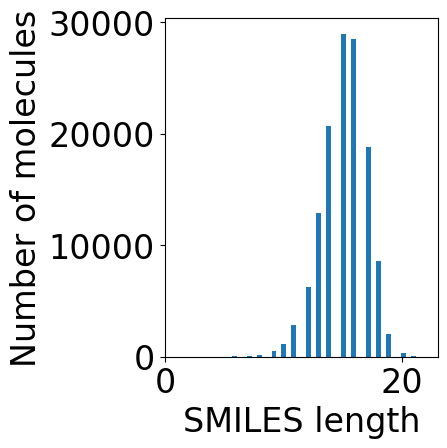

In [7]:
plt.subplots(1, 1, figsize=(5, 5))
plt.hist(df["SMILES"].str.len(), bins=50)
plt.xlabel("SMILES length")
plt.ylabel("Number of molecules")
plt.tight_layout()

In [8]:
max_len = 30 # filter out SMILES longer than this value

df = df[df["SMILES"].str.len() <= max_len]
print(f"Number of molecules after removing long SMILES: {df.shape[0]}")

df["mol"] = df["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))

Number of molecules after removing long SMILES: 132040


In [9]:
df.head()

,idx,SMILES,mol
0,1,C,<rdkit.Chem.rdchem.Mol object at 0x7cef991e6b90>
1,2,N,<rdkit.Chem.rdchem.Mol object at 0x7cef991e7300>
2,3,O,<rdkit.Chem.rdchem.Mol object at 0x7cef991e7bc0>
3,4,C#C,<rdkit.Chem.rdchem.Mol object at 0x7cef991e6f80>
4,5,C#N,<rdkit.Chem.rdchem.Mol object at 0x7cef99060190>


In [10]:
from sklearn.model_selection import train_test_split

# training/validation dataset
data_size = df.shape[0]
test_ratio = 0.10
test_size = int(data_size*test_ratio)
train_indices, test_indices = train_test_split(range(data_size), test_size=test_size, shuffle=True)
print(f"Training size: {len(train_indices)}, test size: {len(test_indices)}")
train_df, val_df = df.iloc[train_indices], df.iloc[test_indices]

Training size: 118836, test size: 13204


In [11]:
train_df.head()

,idx,SMILES,mol
904,905,O=C1C=CNC=N1,<rdkit.Chem.rdchem.Mol object at 0x7cef91774b30>
20486,20487,CC1=NC(CO)=NO1,<rdkit.Chem.rdchem.Mol object at 0x7cef91598e40>
67785,67786,CC12OC1(C#C)C1CC21,<rdkit.Chem.rdchem.Mol object at 0x7cef910ad2a0>
67819,67820,CC12CC1(O)C(=O)OC2,<rdkit.Chem.rdchem.Mol object at 0x7cef910ae180>
10885,10886,CC12COC(C1)C=C2,<rdkit.Chem.rdchem.Mol object at 0x7cef9168c0b0>


## Create PyTorch Dataset

We will use the same tokenizer as in ` Reference_Ch6_Part_2_RNN.ipynb`, just slightly adapt the following classes for generative model:
- Add the option to deal with dataset in lack of target variables for generative models like VAE
- Add two special tokens: `SOS` (start of sentence, initialize the first input token) and `EOS` (end of sentence, terminate generation)

In [12]:
class SMILESDataset(Dataset):
    def __init__(self, df, mol_col, target_col=None, augment=True):
        self.all_df = df
        self.mol_col = mol_col
        self.target_col = target_col
        self.augment = augment

    def _featurize(self, mol):
        smi = Chem.MolToSmiles(mol, doRandom=self.augment)
        return smi

    def __getitem__(self, idx):
        mol = self.all_df.iloc[idx][self.mol_col]
        smi = self._featurize(mol)
        if self.target_col is None:
            # without providing target variables
            return smi
        else:
            # when provided target variable for regression or classification
            target = self.all_df.iloc[idx][self.target_col].values
            target = target.reshape(1, -1).astype(float)
            return smi, torch.from_numpy(target).float()


    def __len__(self):
        return self.all_df.shape[0]


class Collate:
    def __init__(self, tokenizer, pad_token="PAD"):
        self.tokenizer = tokenizer
        self.pad_token = pad_token

    def collate(self, data):
        if not isinstance(data[0], tuple):
            # X for generative model
            smis = [smi for smi in data]
        else:
            # (X, Y) for regression and classification
            smis = [smi for smi, target in data]

        # tokenize SMILES and convert to token ids
        X = [self.tokenizer.encode(smi) for smi in smis]
        max_len = max([len(toks) for toks in X])
        pad_idx = self.tokenizer.token2idx(self.pad_token)

        # padded X
        X = [[pad_idx]*(max_len-len(toks))+list(toks) for toks in X]
        X = torch.Tensor(X).long()

        if not isinstance(data[0], tuple):
            return X
        else:
            n = len(data)
            Y = torch.concat([target.reshape(1, -1) for smi, target in data], dim=0)
            Y = Y.reshape(n, -1).float()
            return X, Y


# reference: https://deepchem.readthedocs.io/en/2.4.0/api_reference/tokenizers.html
SMI_REGEX_PATTERN = r"""(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|
#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""

# convert characters to integers
class Tokenizer():
    def __init__(self):
        self.vocab = ["PAD", "UNK", "SOS", "EOS", "B", "Br", "Cl", "C", "H", \
            "N", "O", "S", "P", "F", "I", \
            "b", "c", "n", "o", "s", "p", "[", "]", \
            "(", ")", ".", " ", "=", "#", \
            "+", "-", ":", "~", "@", "*", "%", \
            "/", "\\", "0", "1", "2", "3", "4", \
            "5", "6", "7", "8", "9"]
        self.i2v = {i: v for i, v in enumerate(self.vocab)}
        self.v2i = {v:i for i, v in enumerate(self.vocab)}

        self.regex_pattern = SMI_REGEX_PATTERN
        self.regex = re.compile(self.regex_pattern)
        self.SOS = self.token2idx("SOS")
        self.EOS = self.token2idx("EOS")
        self.PAD = self.token2idx("PAD")
        self.UNK = self.token2idx("UNK")

    def token2idx(self, v):
        if v in self.vocab:
            return self.v2i[v]
        else:
            return self.v2i["UNK"]

    def encode(self, smi):
        lst = [self.token2idx("SOS"), ]
        tokens = [token for token in self.regex.findall(smi)]
        for v in tokens:
            lst.append(self.token2idx(v))
        lst.append(self.token2idx("EOS"))
        return lst

Test the tokenizer: it is supposed to have `2` (`SOS`) at the begginning of the token ids, and `3` (`EOS`) at the end of the token ids.

In [13]:
tokenizer = Tokenizer()
smi = train_df.iloc[0]["SMILES"]
print(smi)

tokens = [token for token in tokenizer.regex.findall(smi)]
print("Tokens:", tokens)

tok_ids = tokenizer.encode(smi)
print("Token ids:", tok_ids)

O=C1C=CNC=N1
Tokens: ['O', '=', 'C', '1', 'C', '=', 'C', 'N', 'C', '=', 'N', '1']
Token ids: [2, 10, 27, 7, 39, 7, 27, 7, 9, 7, 27, 9, 39, 3]


Test the padding

In [14]:
## this is what we will use for VAE
# post padding
Collate(tokenizer).collate(["c1cccs1", "ClC(C)C"])

tensor([[ 2, 16, 39, 16, 16, 16, 19, 39,  3],
        [ 0,  2,  6,  7, 23,  7, 24,  7,  3]])

## Load Dataset

In [15]:
augment = True
batch_size = 500

tokenizer = Tokenizer()
print("Vocabulary:", tokenizer.vocab)
vocab_size = len(tokenizer.vocab)
print(f"Number of tokens: {vocab_size}")

## batching
instance = Collate(tokenizer)
collate_fn = instance.collate

train_data = SMILESDataset(train_df, mol_col="mol", target_col=None, augment=augment)
train_loader = DataLoader(train_data, \
    batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=False)
test_data = SMILESDataset(val_df, mol_col="mol", target_col=None, augment=augment)
test_loader = DataLoader(test_data, \
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=False)

Vocabulary: ['PAD', 'UNK', 'SOS', 'EOS', 'B', 'Br', 'Cl', 'C', 'H', 'N', 'O', 'S', 'P', 'F', 'I', 'b', 'c', 'n', 'o', 's', 'p', '[', ']', '(', ')', '.', ' ', '=', '#', '+', '-', ':', '~', '@', '*', '%', '/', '\\', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Number of tokens: 48


Each datapoint is just a SMILES string

In [16]:
train_data[0]

'O=c1cc[nH]cn1'

A batch of 5 samples

In [17]:
batch = next(iter(DataLoader(train_data, \
    batch_size=5, shuffle=True, collate_fn=collate_fn, drop_last=False)))
print(batch)

tensor([[ 0,  0,  0,  0,  0,  0,  2, 18, 39, 17, 16, 16, 23, 10,  7, 40,  7,  7,
         40, 24, 17, 39,  3],
        [ 0,  0,  0,  2,  9, 39,  7, 40,  7, 39,  7, 23,  7, 40, 23,  7,  7, 24,
          7, 24, 27, 10,  3],
        [ 2,  7, 39, 40,  7,  7, 41, 23,  7, 42,  7, 23,  9, 40, 41, 24,  7, 42,
         39, 24,  7,  9,  3],
        [ 0,  0,  0,  0,  0,  0,  2,  7, 39,  7, 23,  7,  7, 24, 23,  7, 10, 24,
          7,  7, 39,  7,  3],
        [ 0,  0,  0,  0,  2,  7, 39,  7, 40, 23, 10,  7, 23,  7, 39, 24, 10,  7,
         40, 24,  7,  7,  3]])


## Model

VAE contains an encoder and a decoder. We will use RNN architecture for both encoder and decoder.

You can use different combinations of architectures for encoder and decoder, as long as the encoder can handle the sequences and decoder can generate sequences.

For example, in the [Molecular_VAE_Pytorch](https://github.com/Ishan-Kumar2/Molecular_VAE_Pytorch) implementation, they used `Conv1d` to encode SMILES to a latent space, and decode the latent space to SMILES using `GRU`. They also used fully-connected neural networks for both the encoder and decoder as a baseline.

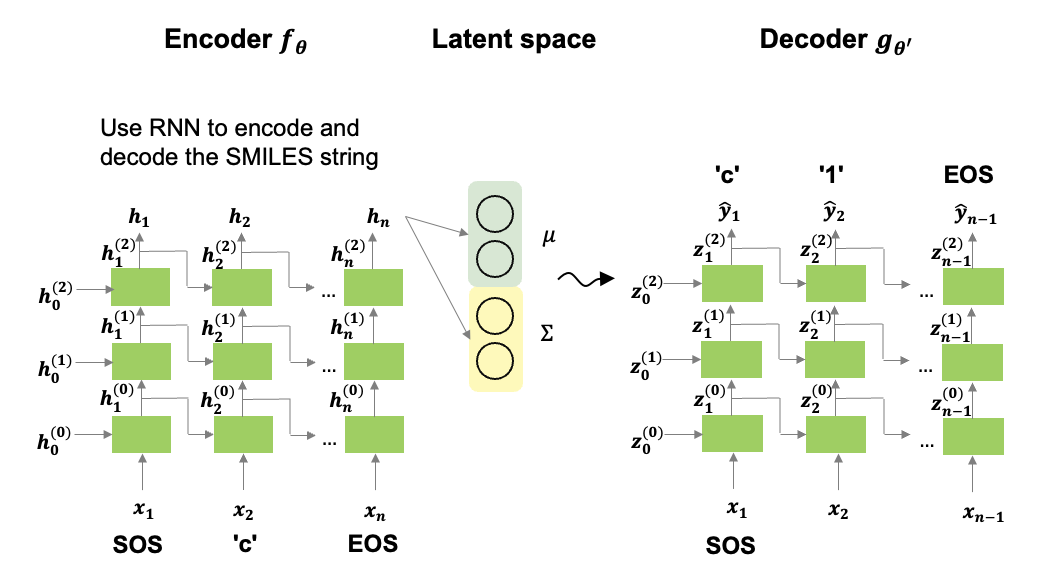

### Encoder

We will re-use some code from `SMILESModel` in ` Reference_Ch6_Part_2_RNN.ipynb` to convert SMILES to a vector, with slightly change:
- Remove the last fully-connected layer `nn.Linear(hidden_dim, 1)` because this is not for regression/classification purposes. We only need to encode each SMILES string to a vector of `hidden_dim` dimensions.

Each SMILES becomes a vector after going through `SMILESModel`. $\mu$ and $\sigma$ in the VAE latent space comes from the

In [18]:
class Encoder(nn.Module):
    def __init__(self,
                  vocab_size, # number of tokens
                  emb_dim, # dimensions of token embedding
                  hidden_dim, # hidden dimension in RNN
                  n_layers, # number of layers in RNN
                  latent_dim, # dimension of the latent space
                  dropout=0.3,
                  rnn_type="lstm",
                  bidirectional=True):
        super(Encoder,self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn_type = rnn_type
        # choose rnn module
        if self.rnn_type == "rnn":
            self.rnn = nn.RNN(emb_dim, hidden_dim, n_layers, dropout=dropout,
                              batch_first=True, bidirectional=bidirectional)
        elif self.rnn_type == "lstm":
            self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout,
                               batch_first=True, bidirectional=bidirectional)
        elif self.rnn_type == "gru":
            self.rnn = nn.GRU(emb_dim, hidden_dim, n_layers, dropout=dropout,
                              batch_first=True, bidirectional=bidirectional)
        else:
            raise ValueError("rnn_type must be 'rnn', 'lstm', or 'gru'")

        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(dropout)

        # mu and sigma
        self.bidirectional = bidirectional
        if self.bidirectional:
            self.mu_fc = nn.Linear(2*hidden_dim, latent_dim)
            self.logvar_fc = nn.Linear(2*hidden_dim, latent_dim)
        else:
            self.mu_fc = nn.Linear(hidden_dim, latent_dim)
            self.logvar_fc = nn.Linear(hidden_dim, latent_dim)

    def forward(self, token_batch):
        x = token_batch.long()
        x = self.embedding(x) # convert ingeters to continuous embeddings
        x, _ = self.rnn(x)
        x = x[:, -1, :] # convert each SMILES string to a vector

        # get mu and logvar
        batch_size = x.shape[0]
        x = nn.ReLU()(x)
        x = x.reshape(batch_size, -1)
        x = self.dropout(x)
        mu, logvar = self.mu_fc(x), self.logvar_fc(x)
        return mu, logvar

### Decoder

The decoder takes the hiddent state $h_{t-1}$ and current input $x_t$ to predict next token $\hat(y)_t$, until hitting `EOS` token or reaching a certain length.

$x_t$ comes from the ground truth or the previous prediction $\hat{y}_{t-1}$

In [19]:
class Decoder(nn.Module):
    def __init__(self, vocab_size,
            embed_dim,
            hidden_dim,
            n_layers,
            dropout,
            rnn_type):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn_type = rnn_type
        self.n_layers = n_layers
        # choose rnn module
        if self.rnn_type == "rnn":
            self.rnn = nn.RNN(embed_dim, hidden_dim, n_layers, dropout=dropout,
                                batch_first=True, bidirectional=False)
        elif self.rnn_type == "lstm":
            self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout,
                                batch_first=True, bidirectional=False)
        elif self.rnn_type == "gru":
            self.rnn = nn.GRU(embed_dim, hidden_dim, n_layers, dropout=dropout,
                                batch_first=True, bidirectional=False)
        else:
            raise ValueError("rnn_type must be 'rnn', 'lstm', or 'gru'")

        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        shape = x.shape
        x = self.embedding(x.long())

        if len(hidden) != 2:
            if len(hidden.shape) == 2:
                # if didn't repeat n_layers times
                hidden = hidden.repeat(self.n_layers, 1, 1)
            if self.rnn_type == "lstm":
                hidden = (hidden, hidden) # hidden state, cell state


        x, hidden = self.rnn(x, hidden)

        x = x.contiguous().reshape(-1, x.shape[-1]) # (B*len, hidden_dim)
        x = self.fc(x) # (B*len, vocab_size)
        x = x.view(*shape, x.shape[-1]) # (B, len, vocab_size)
        return x, hidden

### Unit test of the encoder and decoder class

In [20]:
tok_ids = tokenizer.encode(smi)
# (B=1, len)
tok_tensor = torch.Tensor(tok_ids).reshape(1, -1)
print("Token tensor:", tok_tensor)

## test encoder
enc = Encoder(vocab_size=len(tokenizer.vocab), # number of tokens
    emb_dim=2, # dimensions of token embedding
    hidden_dim=4, # hidden dimension in RNN
    n_layers=2, # number of layers in RNN
    latent_dim=2, # dimension of the latent space
    dropout=0.3,
    rnn_type="lstm",
    bidirectional=True)
mu, logvar = enc(tok_tensor)
print("Shape of mu:", mu.shape)


## test decoder
dec = Decoder(vocab_size=len(tokenizer.vocab),
    embed_dim=2,
    hidden_dim=2,
    n_layers=2,
    dropout=0.3,
    rnn_type="lstm")
sigma = torch.exp(0.5*logvar)
eps = torch.randn_like(sigma).float()
# sample a vector
z = mu + sigma * eps
print("Shape of sampled vector:", z.shape)

# repear for n_layers
# z = z.unsqueeze(1)
# z = z.repeat(2, 1, 1)
print("Shape of initial hidden state for decoder:", z.shape)

x = torch.ones((1, 3)) # three tokens

# decode the vector
x_plus_one, hidden_plus_one = dec(x, z)
# print("Next token logits:", x_plus_one)
print("Shape of next token logits:", x_plus_one.shape) # (B=1, len, vocab_size)
print("Predicted next token id:", x_plus_one.argmax(-1, keepdim=True))

Token tensor: tensor([[ 2., 10., 27.,  7., 39.,  7., 27.,  7.,  9.,  7., 27.,  9., 39.,  3.]])
Shape of mu: torch.Size([1, 2])
Shape of sampled vector: torch.Size([1, 2])
Shape of initial hidden state for decoder: torch.Size([1, 2])
Shape of next token logits: torch.Size([1, 3, 48])
Predicted next token id: tensor([[[34],
         [34],
         [34]]])


### VAE

In [21]:
class Molecule_VAE(nn.Module):
    def __init__(self,
                vocab_size, # number of tokens
                emb_dim, # dimensions of token embedding
                enc_hidden_dim, # hidden dimension in encoder
                enc_n_layers, # number of layers in encoder
                enc_rnn_type,
                enc_bidirectional,
                latent_dim, # dimension of the latent space
                dec_n_layers, # number of layers in decoder
                dec_rnn_type,
                dropout=0.3,
                tokenizer=Tokenizer()):

        super(Molecule_VAE, self).__init__()
        self.encoder = Encoder(vocab_size,
                            emb_dim,
                            enc_hidden_dim,
                            enc_n_layers,
                            latent_dim,
                            dropout,
                            enc_rnn_type,
                            enc_bidirectional)

        dec_hidden_dim = latent_dim
        self.decoder = Decoder(vocab_size,
                            emb_dim,
                            dec_hidden_dim, # takes the latent vector as hidden state
                            dec_n_layers,
                            dropout,
                            dec_rnn_type)
        self.latent_dim = latent_dim
        self.tokenizer = tokenizer

    def reparameterize(self, mu, logvar):
        """Return the latent normal sample z ~ N(mu, sigma^2)"""
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std).to(mu.device)
        return mu + eps*std

    def forward(self, x):
        """Forward Function which passes the data through entire model"""
        mu, logvar = self.encoder(x) # latent space
        z = self.reparameterize(mu, logvar) # sampled from latent space
        hidden = z.unsqueeze(0).repeat(self.decoder.n_layers, 1, 1)
        recon_x, hidden = self.decoder(x, hidden) # use the true labesl in the training data x as input for decoder
        return recon_x, mu, logvar

### Train Utils

#### Define loss function

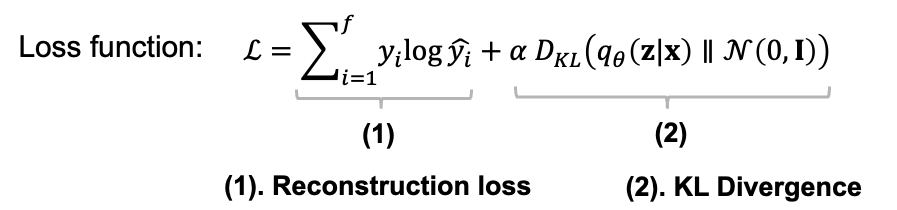

In [22]:
def vae_loss_function(recon_x, x, mu, logvar, alpha_KDL=1.0e-05):
    """Return cross entropy loss (reconstruction) and KL divergence"""
    CE = nn.CrossEntropyLoss()(recon_x, x)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return CE, alpha_KDL*KLD

#### Training and validation functions

Pay attention to the tokens to compare:

For example: the input token ids of `c1cccs1` is `[ 2, 16, 39, 16, 16, 16, 19, 39,  3]`, where `2` is the id of `<SOS>` and `3` is the id of `<EOS>`.

The ideal prediction should be `[16, 39, 16, 16, 16, 19, 39,  3, x]`. Here `x` denotes whatever token after the `<EOS>` token. For this input of length=$9$, we only match tokens $8$ times by comparing  `[2, 16, 39, 16, 16, 16, 19, 39]` to `[16, 39, 16, 16, 16, 19, 39,  3]`.

In [23]:
def train_one_epoch(model, criterion, optimizer, dataloader, clip):
    model.train()
    train_loss = []
    for x in dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        output, mu, logvar = model(x)

        pred = output[:, :-1, :]
        pred = pred.reshape(-1, pred.shape[-1]) # (B*(len-1), vocab_size), unormalized logits
        truth = x[:, 1:]
        truth = truth.reshape(-1) # (B*(len-1), ), labels

        ce, kld = criterion(pred, truth, mu, logvar) # we want to keep track of two losses separately
        loss = ce + kld
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        train_loss.append([ce.detach().cpu().numpy(), kld.detach().cpu().numpy()])
    return train_loss

def val_one_epoch(model, criterion, dataloader):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for x in dataloader:
            x = x.to(device)
            output, mu, logvar = model(x)

            pred = output[:, :-1, :]
            pred = pred.reshape(-1, pred.shape[-1])
            truth = x[:, 1:]
            truth = truth.reshape(-1)

            ce, kld = criterion(pred, truth, mu, logvar)
            val_loss.append([ce.detach().cpu().numpy(), kld.detach().cpu().numpy()])
    return val_loss

## Training

In [24]:
vocab_size = len(Tokenizer().vocab)
lr = 1e-3
emb_dim = 32
enc_hidden_dim = 64
dropout = 0.3
enc_n_layers = 3
enc_rnn_type = "lstm"
enc_bidirectional = True
latent_dim = 64
dec_n_layers = 3
dec_rnn_type = "lstm"
clip = 10 # mitigate gradient exploding/vanishing in BPTT

model = Molecule_VAE(vocab_size, # number of tokens
        emb_dim, # dimensions of token embedding
        enc_hidden_dim, # hidden dimension in encoder
        enc_n_layers, # number of layers in encoder
        enc_rnn_type,
        enc_bidirectional,
        latent_dim, # dimension of the latent space
        dec_n_layers, # number of layers in decoder
        dec_rnn_type,
        dropout=0.3,
        tokenizer=Tokenizer())
model.to(device)
model = model.float()

print("Number of trainable parameters:",
      sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# feel free to try different alpha_KDL
alpha_KDL=1.0e-05

from functools import partial
criterion = partial(vae_loss_function, alpha_KDL=alpha_KDL)

Number of trainable parameters: 363184


Since this model takes a while to train, we don't want to re-train every time. We can save `checkpoints` with trained parameters and optimizer states every a few epochs. We can load the trained parameters to the model from the checkpoint files.

In [25]:
n_epochs = 100
log_interval = 10

logdir = f"params_thres{max_len}_epochs{n_epochs}_qm9_alpha{alpha_KDL}" # log directory
os.makedirs(logdir, exist_ok=True)
final_file = os.path.join(logdir, f"final_params.pth")


train_loss = []
val_loss = []

### Skip the following block if the model is trained.

In [26]:
for epoch in tqdm.tqdm(range(n_epochs)):
    losses = train_one_epoch(model, criterion, optimizer, train_loader, clip)
    mean_loss = np.mean(np.array(losses), axis=0)
    train_loss.append([mean_loss[0], mean_loss[1]])

    losses = val_one_epoch(model, criterion, test_loader)
    mean_loss = np.mean(np.array(losses), axis=0)
    val_loss.append([mean_loss[0], mean_loss[1]])

    if epoch % log_interval == 0:
        # print loss
        print(f"Training CE: {train_loss[-1][0]:.4f}, Training KL: {train_loss[-1][1]:.4f}")
        print(f"Validation CE: {val_loss[-1][0]:.4f}, Validation KL: {val_loss[-1][1]:.4f}")

        # save checkpoint
        checkpoint = {
            "train_loss": train_loss,
            "val_loss": val_loss,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        torch.save(checkpoint, os.path.join(logdir, f"checkpoint_epoch{epoch}.pth"))

# save final model
checkpoint = {
    "train_loss": train_loss,
    "val_loss": val_loss,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}
torch.save(checkpoint, os.path.join(logdir, f"final_params.pth"))

  1%|          | 1/100 [00:22<37:52, 22.95s/it]

Training CE: 1.8981, Training KL: 0.0000
Validation CE: 1.5727, Validation KL: 0.0001


 11%|█         | 11/100 [04:33<37:14, 25.11s/it]

Training CE: 0.8912, Training KL: 0.0001
Validation CE: 0.8410, Validation KL: 0.0001


 21%|██        | 21/100 [08:44<33:07, 25.16s/it]

Training CE: 0.6999, Training KL: 0.0001
Validation CE: 0.6623, Validation KL: 0.0001


 31%|███       | 31/100 [12:53<28:36, 24.88s/it]

Training CE: 0.5933, Training KL: 0.0001
Validation CE: 0.5230, Validation KL: 0.0001


 41%|████      | 41/100 [17:02<24:26, 24.86s/it]

Training CE: 0.5141, Training KL: 0.0001
Validation CE: 0.4368, Validation KL: 0.0001


 51%|█████     | 51/100 [21:12<20:31, 25.12s/it]

Training CE: 0.4376, Training KL: 0.0001
Validation CE: 0.3387, Validation KL: 0.0001


 61%|██████    | 61/100 [25:21<16:07, 24.81s/it]

Training CE: 0.3747, Training KL: 0.0001
Validation CE: 0.2564, Validation KL: 0.0001


 71%|███████   | 71/100 [29:29<12:00, 24.85s/it]

Training CE: 0.3241, Training KL: 0.0001
Validation CE: 0.2093, Validation KL: 0.0001


 81%|████████  | 81/100 [33:38<07:51, 24.84s/it]

Training CE: 0.2847, Training KL: 0.0001
Validation CE: 0.1783, Validation KL: 0.0001


 91%|█████████ | 91/100 [37:48<03:44, 24.92s/it]

Training CE: 0.2554, Training KL: 0.0001
Validation CE: 0.1436, Validation KL: 0.0001


100%|██████████| 100/100 [41:32<00:00, 24.92s/it]


### Load from trained file

In [27]:
ckpt_file = os.path.join(logdir, "final_params.pth")
checkpoint = torch.load(ckpt_file, weights_only=False, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
print(f"Loaded parameters from existing file. "\
    f"Please manually detele {final_file} if you want to re-train the model")
train_loss = checkpoint["train_loss"]
val_loss = checkpoint["val_loss"]

Loaded parameters from existing file. Please manually detele params_thres30_epochs100_qm9_alpha1e-05/final_params.pth if you want to re-train the model


An empirical note on the cross entropy loss of multi-class classification tasks: For a multi-class problem with $n$ classes, a random guessing baseline would have a cross-entropy value around $\log{n}$ (natrual log). For example, most of the time you would see the initial loss of balanced binary classification around $0.69=\log{2}$. Imbalanced labels may slightly decrease this value.

The random baseline of $48$-class classification would be ~$3.87=\log{48}$. We would expect the loss of our model smaller than this value, otherwise the model cannot beat random guess.

Plot cross entropy loss

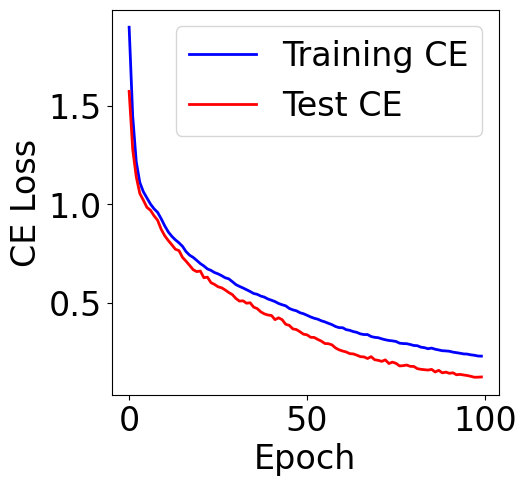

In [28]:
train_loss = checkpoint["train_loss"]
val_loss = checkpoint["val_loss"]

f, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot([item[0] for item in train_loss], c="blue", label="Training CE")
ax.plot([item[0] for item in val_loss], c="red", label="Test CE")
plt.xlabel("Epoch")
plt.ylabel("CE Loss")
plt.legend()

Plot KL divergence

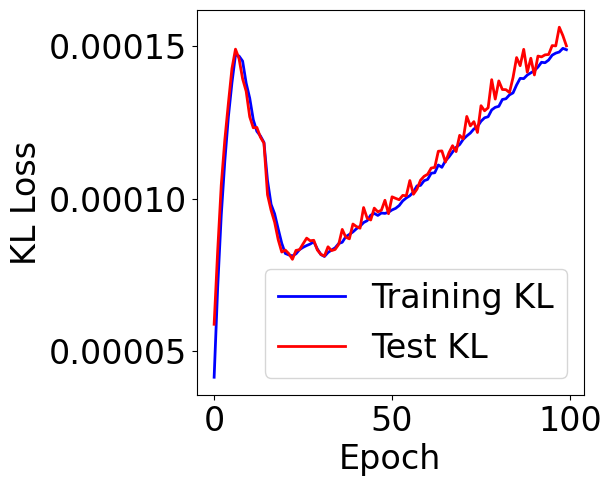

In [29]:
f, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot([item[1] for item in train_loss], c="blue", label="Training KL")
ax.plot([item[1] for item in val_loss], c="red", label="Test KL")
plt.xlabel("Epoch")
plt.ylabel("KL Loss")
plt.legend()

Plot total loss

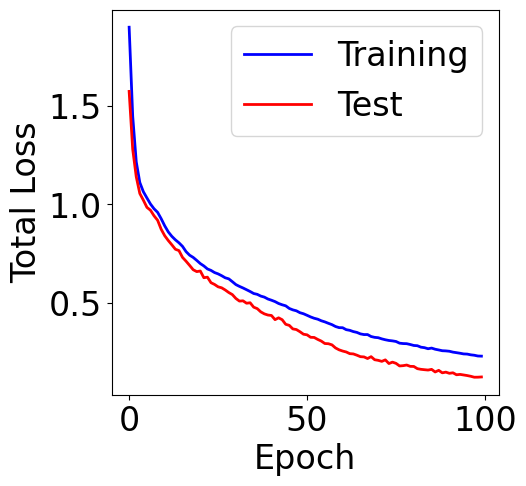

In [30]:
train_loss = checkpoint["train_loss"]
val_loss = checkpoint["val_loss"]

f, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot([item[0]+item[1] for item in train_loss], c="blue", label="Training")
ax.plot([item[0]+item[1] for item in val_loss], c="red", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.legend()

## Evaluation Metrics

Since this is a generative model, we will evaluate the model performance from two perspectives:

- Generative performance:
    + The validity ratio of generated SMILES: We will sample $k$ latent vectors for each compound in the validation set, and generate SMILES using the $k$ latent vectors. Use `rdkit` to test the validity of generated SMILES.
    + Novelty: How many generated molecules are unseen in the compound library
    + Property distribution: Does the generated molecules have similar property distribution to the training compounds, e.g. logP, QED, synthetic accessibility (SAScore), etc.  

#### Evaluate generation performance

Unlike in training when we feed in the ground truth (teacher forcing), we will utilize the predicted token as next token during the generation process.

We will randomly sample $n$ compounds from the validation set, and generate $k$ samples by pertubating the latent vector of each sampled compound. When more resources are available, feel free to generate more compounds. We will generate tokens up to `max_length`, and truncate the generated sequence when hitting `<EOS>` token.

Sample new points from the latent distributions: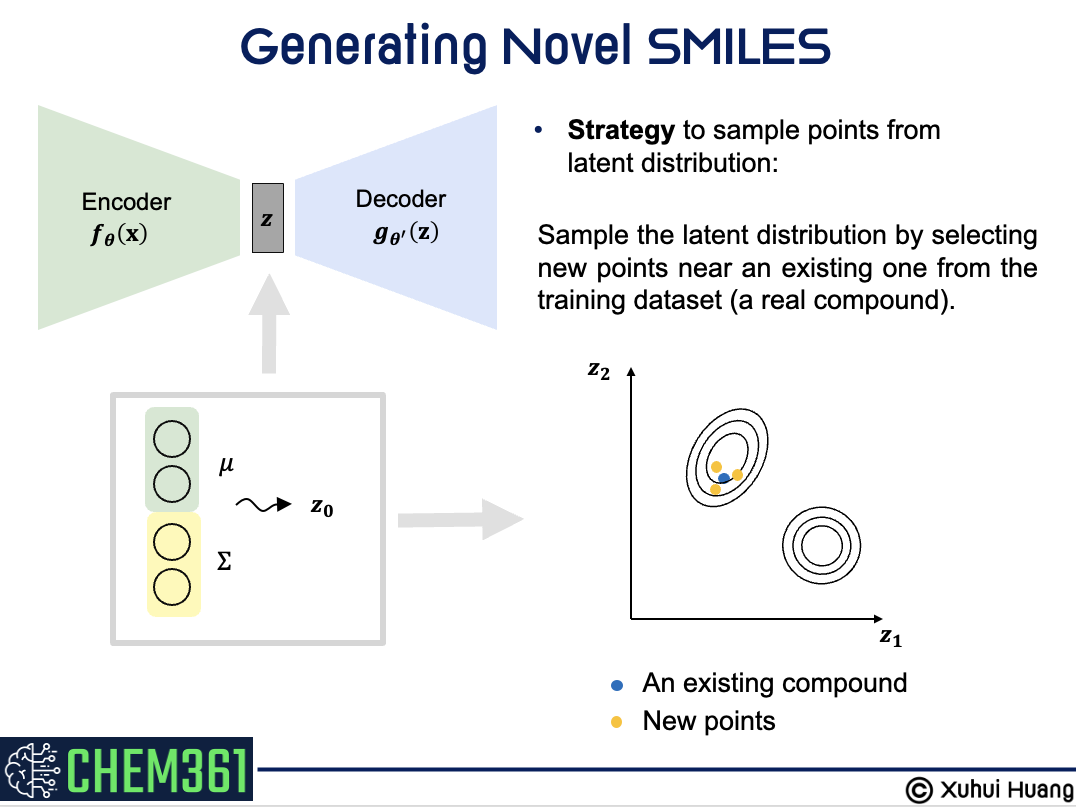

In [31]:
probabilities = []
predictions = []
truths = []
model.eval()

max_length = max_len

# change these two values to control the number of compounds to generate
n_compounds = 100
k_samples = 5

comp_indices = np.random.choice(val_df.shape[0], n_compounds, replace=False)
gen_data = SMILESDataset(val_df.iloc[comp_indices, :], mol_col="mol", target_col=None, augment=augment)
gen_loader = DataLoader(gen_data, \
    batch_size=1, shuffle=False, collate_fn=collate_fn, drop_last=False)

Take a look at the sampled compounds (real compounds in the compound library)

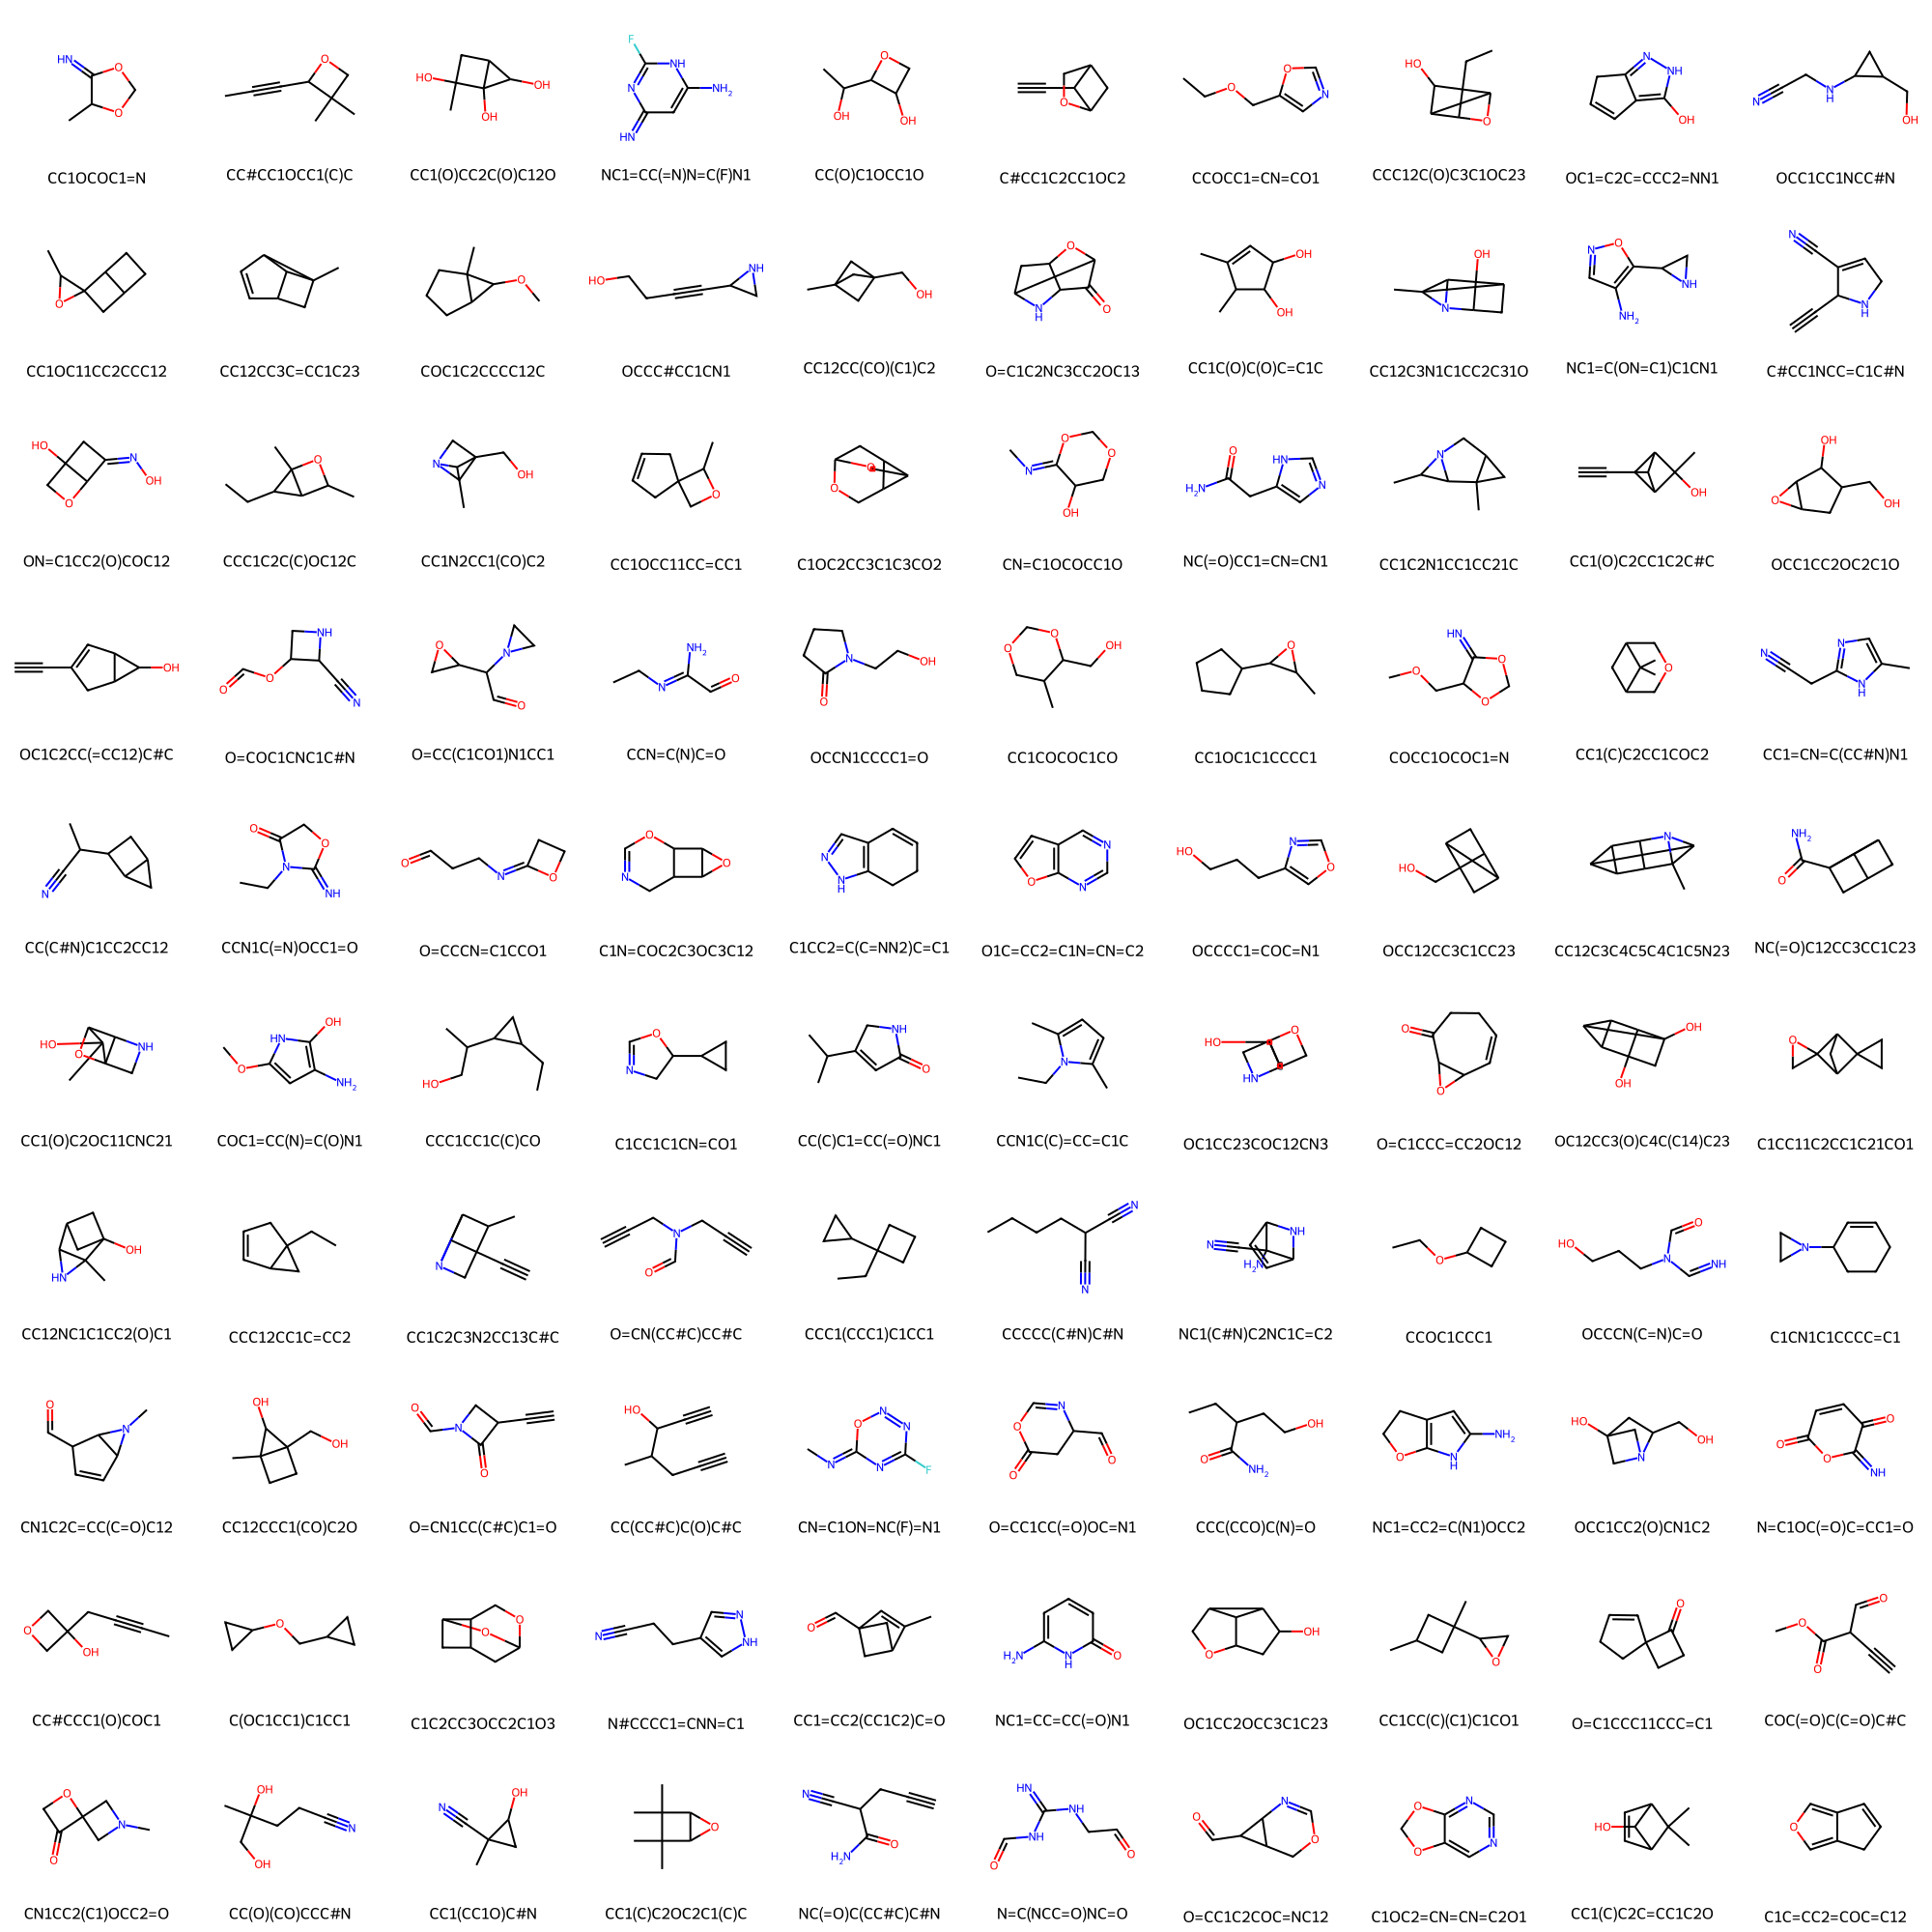

In [32]:
import rdkit.Chem.Draw as Draw
Draw.MolsToGridImage(val_df.iloc[comp_indices]["mol"], molsPerRow=10,
                     legends=val_df.iloc[comp_indices]["SMILES"].values.tolist(), maxMols=1000)

Start generating compounds

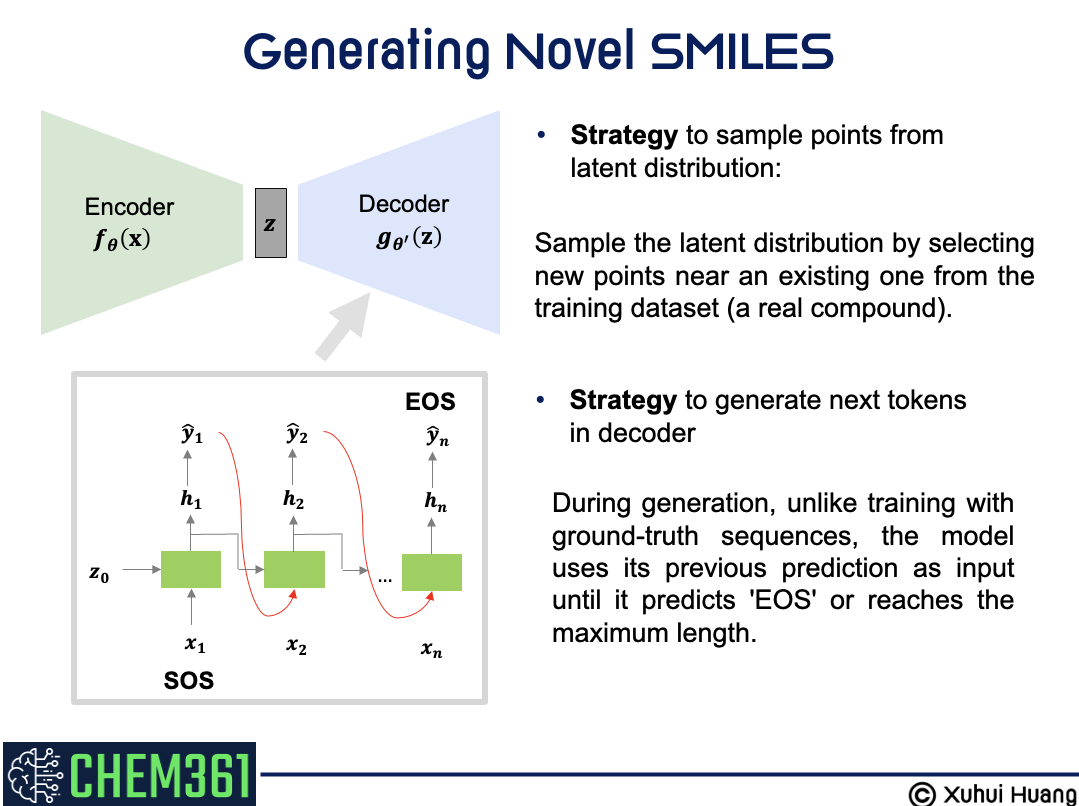

In [33]:
generated_token_ids = []

with torch.no_grad():
    for x in gen_loader:
        if device == "cuda":
            x = x.to(device)
        _, mu, logvar = model(x)

        # sample n_samples times from latent space
        mu = mu.repeat(k_samples, 1)
        logvar = logvar.repeat(k_samples, 1)
        z = model.reparameterize(mu, logvar)

        # the latent space will be the initial hidden state of the decoder
        hidden = z

        # initial input: (B, 1) with <SOS> id
        SOS_token = tokenizer.SOS
        input_ = torch.full((k_samples, 1), SOS_token, dtype=torch.long, device=z.device)

        outputs = torch.zeros(k_samples, max_length).to(z.device)

        # generate SMILES
        for t in range(max_length):
            # output has the shape of (B, 1, vocab_size)
            output, hidden_next = model.decoder(input_, hidden)
            output = nn.Softmax(dim=-1)(output) # probabilities
            output = torch.argmax(output, dim=-1) # predicted label with max prob

            # update input and hidden state
            outputs[:, t:t+1] = output
            input_ = output
            hidden = hidden_next

        outputs = outputs.cpu().numpy()
        generated_token_ids.append(outputs)

In [34]:
# clean up generated SMILES
concat_token_ids = np.vstack(generated_token_ids)

EOS_token = tokenizer.EOS
eos_positions = (concat_token_ids == EOS_token)

# locate index of the first <EOS>, or return -1 if no <EOS>
eos_positions = np.where(np.sum(eos_positions, axis=-1)>0, eos_positions.argmax(axis=-1), -1)

truncated_sequences = []

for idx in range(concat_token_ids.shape[0]):
    eos_idx = eos_positions[idx]
    if eos_idx != -1:
        token_ids = concat_token_ids[idx, :eos_idx]
    else:
        token_ids = concat_token_ids[idx, :]

    generated_tokens = [tokenizer.i2v[i] for i in token_ids if i != tokenizer.PAD]
    generated_smi = "".join(generated_tokens) # concat tokens to string
    if len(generated_smi) > 0:
        truncated_sequences.append(generated_smi)

print("All generated SMILES:")
print(truncated_sequences)

All generated SMILES:
['C1=NC(=N)C(=N)C1(C)C', 'C1=NC(=N)C(=N)C1(C)C', 'C1=NC(=N)C(=N)C1(C)C', 'C1=NC(=N)C(=N)C1(C)C', 'C1=NC(=N)C(=N)C1(C)C', 'SOSC(CC)(CN)C12C(C1)N2', 'SOSC(CC)(CN)C12C(C1)N2', 'SOSC(CC)(CN)C12C(C1)N2', 'SOSC(CC)(CN)C12C(C1)N2', 'SOSC(CC)(CN)C12C(C1)N2', 'C1(CC2(C1)N(C2)=N)CN', 'C1(CC2(C1)N(C2)=N)CN', 'C1(CC2(C1)N(C2)=N)CN', 'C1(CC2(C1)N(C2)=N)CN', 'C1(CC2(C1)N(C2)=N)CN', 'N=C1C2(CN(C2)=O)C1', 'N=C1C2(CN(C2)=O)C1', 'N=C1C2(CN(C2)=O)C1', 'N=C1C2(CN(C2)=O)C1', 'N=C1C2(CN(C2)=O)C1', 'C1(C(O)(C)C1)N(C)C', 'C1(C(O)(C)C1)N(C)C', 'C1(C(O)(C)C1)N(C)C', 'C1(C(O)(C)C1)N(C)C', 'C1(C(O)(C)C1)N(C)C', 'C(C)C1C2C1C(C)O2)C', 'C(C)C1C2C1C(C)O2)C', 'C(C)C1C2C1C(C)O2)C', 'C(C)C1C2C1C(C)O2)C', 'C(C)C1C2C1C(C)O2)C', 'SOSCNC(C)c1n2C(C2)C1', 'SOSCNC(C)c1n2C(C2)C1', 'SOSCNC(C)c1n2C(C2)C1', 'SOSCNC(C)c1n2C(C2)C1', 'SOSCNC(C)c1n2C(C2)C1', 'C12C3(C(O)C2C3(C1)O)C', 'C12C3(C(O)C2C3(C1)O)C', 'C12C3(C(O)C2C3(C1)O)C', 'C12C3(C(O)C2C3(C1)O)C', 'C12C3(C(O)C2C3(C1)O)C', 'C1C2(N3C1C3C)C(F)=N2', 'C1C2(N3

Validity of generated SMILES

In [35]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

success_count = 0
successed_smi = []
for smi in truncated_sequences:
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            success_count += 1
            successed_smi.append(smi)
    except:
        continue

print(f"Validity ratio of generated SMIMLES: {success_count/len(truncated_sequences)*100:.2f}%")
print("Valid generated SMILES:")
print(successed_smi)

Validity ratio of generated SMIMLES: 62.00%
Valid generated SMILES:
['C1=NC(=N)C(=N)C1(C)C', 'C1=NC(=N)C(=N)C1(C)C', 'C1=NC(=N)C(=N)C1(C)C', 'C1=NC(=N)C(=N)C1(C)C', 'C1=NC(=N)C(=N)C1(C)C', 'SOSC(CC)(CN)C12C(C1)N2', 'SOSC(CC)(CN)C12C(C1)N2', 'SOSC(CC)(CN)C12C(C1)N2', 'SOSC(CC)(CN)C12C(C1)N2', 'SOSC(CC)(CN)C12C(C1)N2', 'C1(C(O)(C)C1)N(C)C', 'C1(C(O)(C)C1)N(C)C', 'C1(C(O)(C)C1)N(C)C', 'C1(C(O)(C)C1)N(C)C', 'C1(C(O)(C)C1)N(C)C', 'C12C3(C(O)C2C3(C1)O)C', 'C12C3(C(O)C2C3(C1)O)C', 'C12C3(C(O)C2C3(C1)O)C', 'C12C3(C(O)C2C3(C1)O)C', 'C12C3(C(O)C2C3(C1)O)C', 'C1C2(N3C1C3C)C(F)=N2', 'C1C2(N3C1C3C)C(F)=N2', 'C1C2(N3C1C3C)C(F)=N2', 'C1C2(N3C1C3C)C(F)=N2', 'C1C2(N3C1C3C)C(F)=N2', 'C1(OC12C1C(C2)C1)CC', 'C1(OC12C1C(C2)C1)CC', 'C1(OC12C1C(C2)C1)CC', 'C1(OC12C1C(C2)C1)CC', 'C1(OC12C1C(C2)C1)CC', 'C1C2C3C(C2C3)C(C=1)C', 'C1C2C3C(C2C3)C(C=1)C', 'C1C2C3C(C2C3)C(C=1)C', 'C1C2C3C(C2C3)C(C=1)C', 'C1C2C3C(C2C3)C(C=1)C', 'SOS1(C)C2C3C4CC(C41C2)C3', 'SOS1(C)C2C3C4CC(C41C2)C3', 'SOS1(C)C2C3C4CC(C41C2)C3', 'SOS1(C

Uniqueness of valid SMILES

In [36]:
unique_mols = []
for smi in successed_smi:
    mol = Chem.MolFromSmiles(smi)
    is_new = True
    for ref_mol in unique_mols:
        s1 = mol.HasSubstructMatch(ref_mol)
        s2 = ref_mol.HasSubstructMatch(mol)
        if s1 and s2:
            is_new = False
            break
    if is_new:
        unique_mols.append(mol)

print(f"Uniqueness ratio in valid SMILES: {len(unique_mols)/len(successed_smi)*100:.2f}%")

Uniqueness ratio in valid SMILES: 20.32%


Visualize unique generated molecules

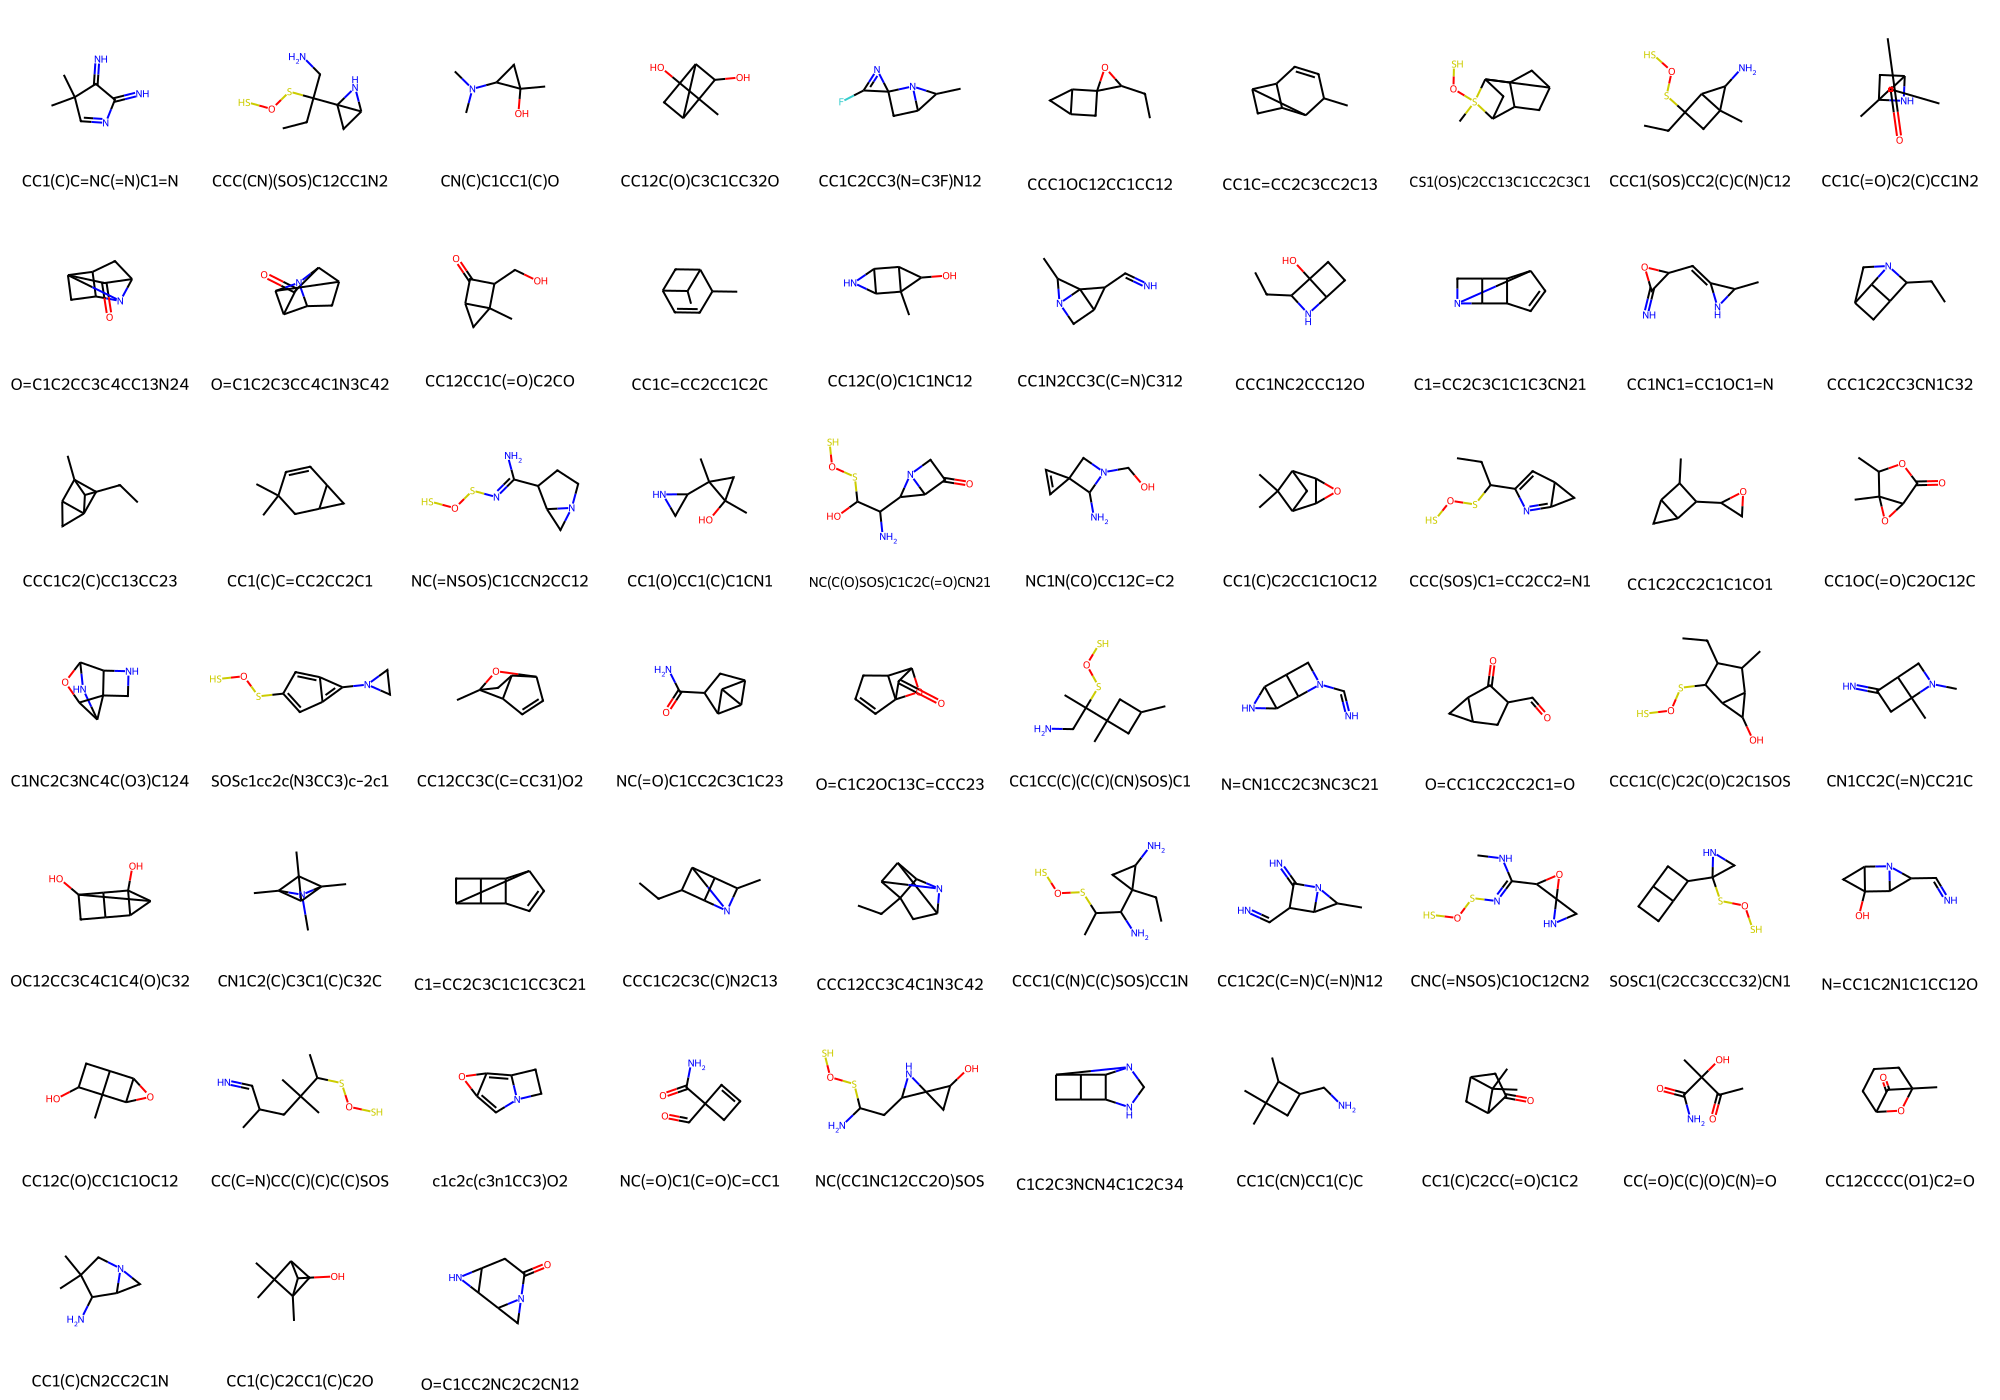

In [37]:
unique_smi = [Chem.MolToSmiles(mol) for mol in unique_mols]
Draw.MolsToGridImage(unique_mols, molsPerRow=10, legends=unique_smi, maxMols=1000)

Novelty ratio of generated SMILES by comparing to compounds in the QM9 dataset.

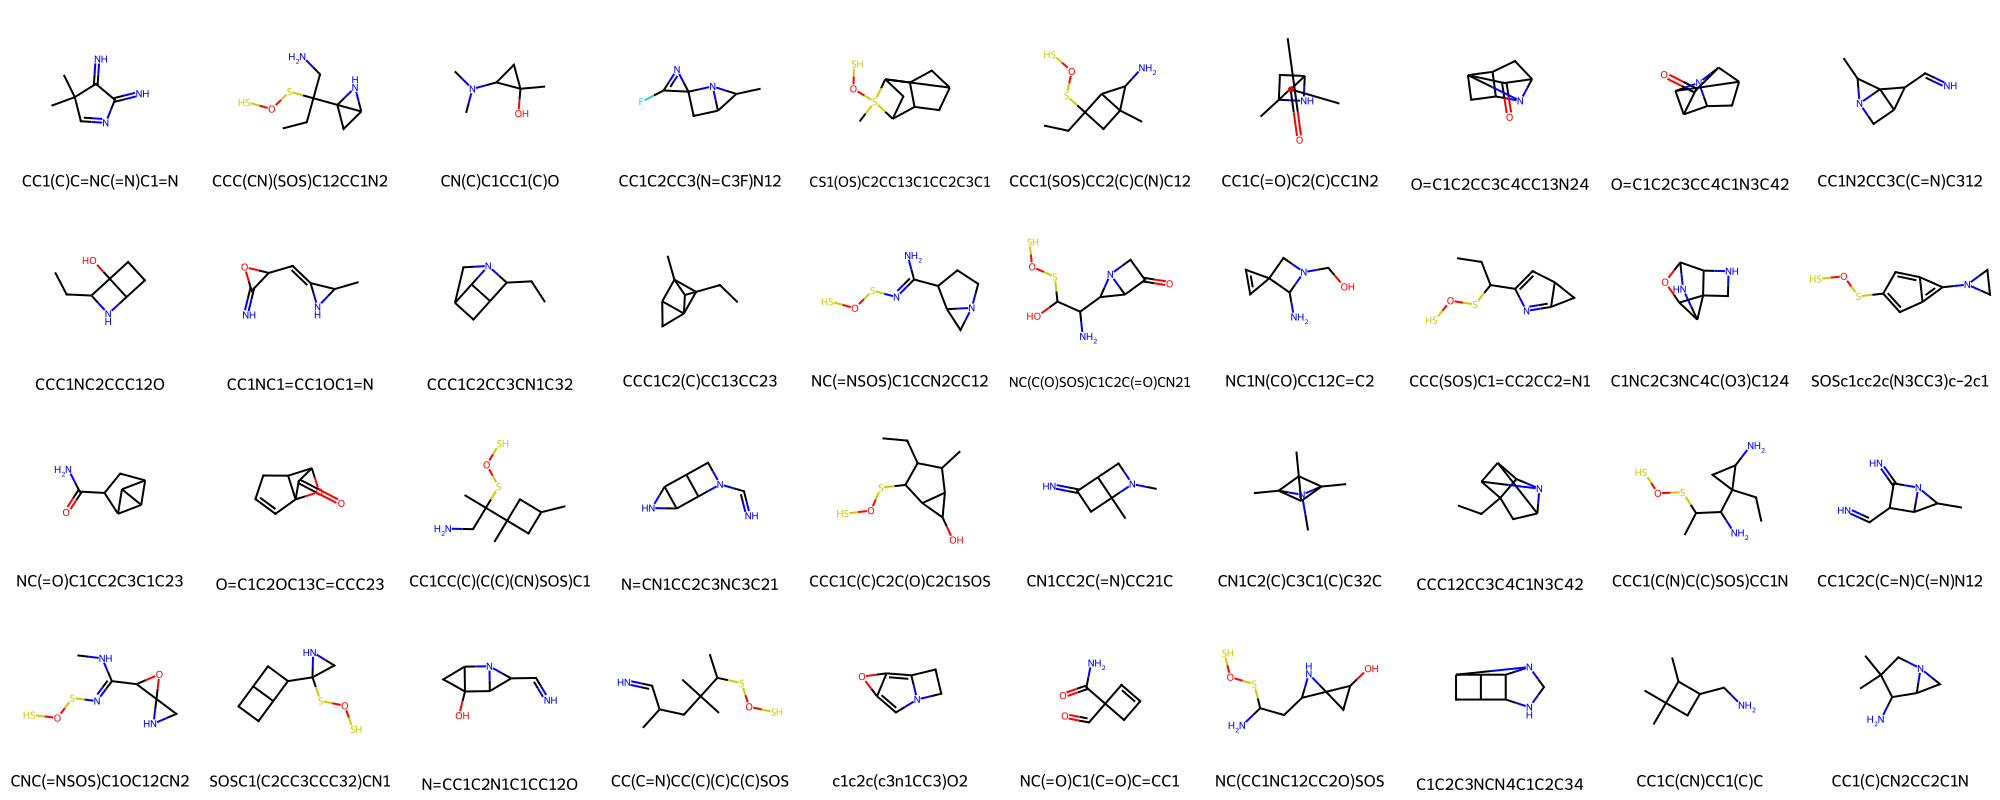

In [38]:
def is_novel(mol):
    hit = df["mol"].apply(lambda x: x.HasSubstructMatch(mol) and mol.HasSubstructMatch(x))
    return not any(hit)

novel_mols = []
for mol in unique_mols:
    if is_novel(mol):
        novel_mols.append(mol)

novel_smi = [Chem.MolToSmiles(mol) for mol in novel_mols]
Draw.MolsToGridImage(novel_mols, molsPerRow=10, legends=novel_smi)

In [39]:
print(f"Novelty ratio in unique SMILES: {len(novel_mols)/len(unique_mols)*100:.2f}%")

Novelty ratio in unique SMILES: 63.49%


#### Distribution of Properties

In [40]:
# # ## Download source code to compute synthetic availability score from rdkit
# !python -m wget https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/SA_Score/sascorer.py
# !python -m wget https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/SA_Score/fpscores.pkl.gz

In [41]:
from rdkit.Chem import Descriptors
import os, sys
from rdkit.Chem import RDConfig
# using literature contributors
# from https://github.com/rdkit/rdkit/tree/master/Contrib
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

Calculate properties of molecules in the compound library (validation data sampled from ZINC), and properties of generated molecules

In [42]:
mols_in_lib = val_df.iloc[comp_indices]["mol"].values.tolist()
mols_generated = unique_mols

eval_df = pd.DataFrame({"mol": mols_in_lib+mols_generated})
eval_df["label"] = ["lib"]*len(mols_in_lib) + ["gen"]*len(mols_generated)
eval_df["logP"] = eval_df["mol"].apply(Descriptors.MolLogP)
eval_df["qed"] = eval_df["mol"].apply(Descriptors.qed)
eval_df["SAS"] = eval_df["mol"].apply(sascorer.calculateScore)

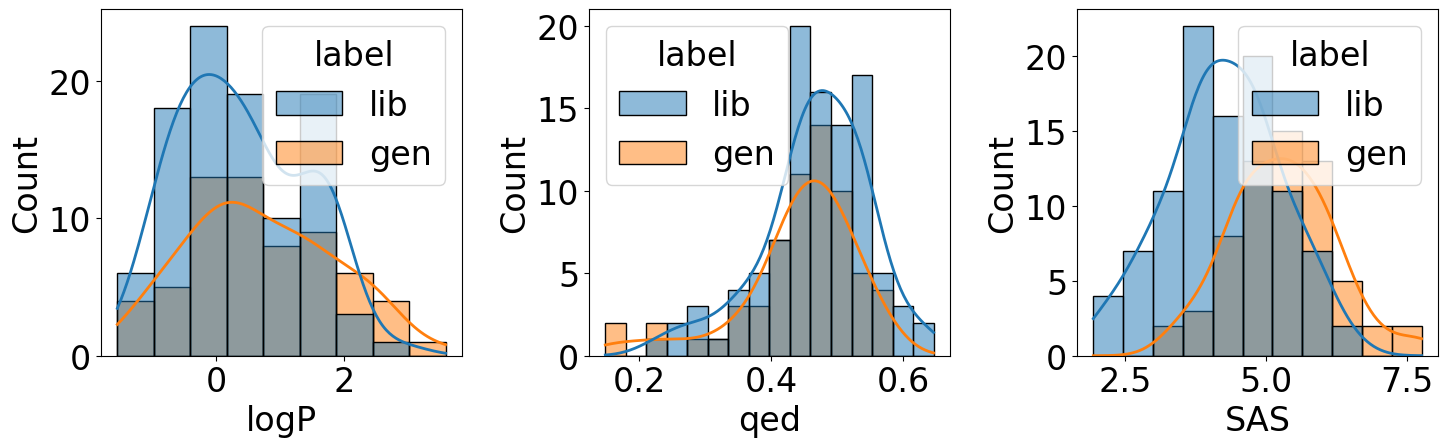

In [43]:
properties = ["logP", "qed", "SAS"]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()
for i, prop in enumerate(properties):
    sns.histplot(data=eval_df, hue="label", kde=True, x=prop, ax=axs[i])
plt.tight_layout()

A conclusion remark: in this notebook, we RNN (chapter 6) and VAE (chapter 7) to build a generative model for SMILES, evaluated the model performance using confusion matrix and MSE (chapter 4), and validated the molecular property (chapter 2) distributions.